# Implementation of an MLP using Torch

In [36]:
#Imports
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Opening the names file
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()[:10000] # Usamos solo el primer millon de dominios
dataset[:8]

['google.com',
 'a-msedge.net',
 'microsoft.com',
 'facebook.com',
 'amazonaws.com',
 'googleapis.com',
 'apple.com',
 'youtube.com']

In [38]:
# Opening the names file
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_len = len(charset)


In [39]:
print(ctoi)

{'*': 0, '-': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38}


In [40]:
# Constructing the datasets
def build_dataset(dataset: list):
    X, Y  = [], []
    for d in dataset:
        example = list(d) + ['*']
        context = [0] * context_size
        for c in example:
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]] 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [41]:
# Constructing the datasets
context_size = 3
np.random.seed(42)
np.random.shuffle(dataset)
n1 = int(.8 * len(dataset))  # 80% split
n2 = int(.9 * len(dataset))  # 90% split

Xtr, Ytr = build_dataset(dataset[:n1])    # 80% train
Xva, Yva = build_dataset(dataset[n1:n2])  # 10% val
Xte, Yte = build_dataset(dataset[:n2])    # 10% test

In [42]:
# MLP setup 
g = torch.Generator(device='cpu').manual_seed(42)
emb_d = 10  # Embedding dimensions
input_size = context_size * emb_d  # Input size (flattened)
n_hidden = 128  # Hidden layer neurons

# Defining the model
C = torch.randn((charset_len, emb_d),             generator=g)
W1 = torch.randn((emb_d * context_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, charset_len),         generator=g)
b2 = torch.randn(charset_len,                     generator=g)

parameters = [C, W1, b1, W2, b2]

# Enable grad for backprop
for p in parameters:
    p.requires_grad = True

# Checking total param count
sum(p.nelement() for p in parameters)

9389

In [43]:
train_iterations = 100000
minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop with mini-batches
    ix = torch.randint(0, len(Xtr), (minibatch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass using cross_entropy
    emb = C[Xb]  # char embeddings
    embcat = emb.view(-1, input_size)  # flatten embeddings
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    h = torch.tanh(hpreact)  # hidden layer activation
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update step
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())

print(loss.item())

Step:       0/ 100000 -- loss: 24.725157
Step:   10000/ 100000 -- loss: 2.415473
Step:   20000/ 100000 -- loss: 2.278767
Step:   30000/ 100000 -- loss: 2.101117
Step:   40000/ 100000 -- loss: 2.237614
Step:   50000/ 100000 -- loss: 2.195081
Step:   60000/ 100000 -- loss: 2.197257
Step:   70000/ 100000 -- loss: 1.955669
Step:   80000/ 100000 -- loss: 2.185173
Step:   90000/ 100000 -- loss: 2.451750
2.385845184326172


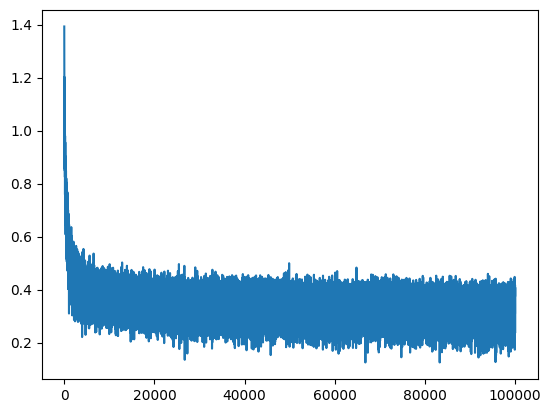

In [44]:
#Loss view
plt.plot(loss_log)

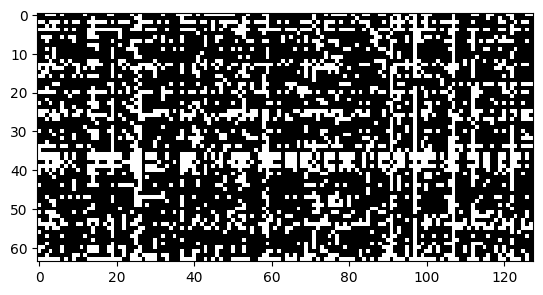

In [45]:
#Dead neurons visualizer
plt.imshow(h.abs() > 0.99, cmap='gray')

In [46]:
#Defining the layers

class Embedding():
    def __init__(self, n_embeddings, embedding_dimension):
        self.weight = torch.randn((n_embeddings, embedding_dimension))
    
    def __call__(self, x):
        self.out = self.weight[x]
        self.out = self.out.view(self.out.shape[0], -1)
        return self.out

    def parameters(self):
        return [self.weight]


class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

## Practice time!
The code below has some bugs. Basically, the training loop isn't learning anything (loss isn't going down) after the second loop. Gotta find the error.

In [47]:
context_size = 3
emb_d = 10
n_hidden = 128

model = [
    Embedding(charset_len, emb_d),
    Linear(emb_d*context_size, n_hidden), Tanh(),
    Linear(n_hidden, charset_len)
]

parameters = [p for layer in model for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum((p.nelement() for p in parameters))}')

Number of parameters: 9389


In [48]:
train_iterations = 100000
minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop en mini batches
    ix = torch.randint(0, len(Xtr), (minibatch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    x = Xb
    # forward pass
    for layer in model:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in model:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad #p.data *= -lr * p.grad
    
    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())
print(loss.item())
    

Step:       0/ 100000 -- loss: 19.108835
Step:   10000/ 100000 -- loss: 2.588462
Step:   20000/ 100000 -- loss: 2.337696
Step:   30000/ 100000 -- loss: 2.232477
Step:   40000/ 100000 -- loss: 2.208829
Step:   50000/ 100000 -- loss: 1.946833
Step:   60000/ 100000 -- loss: 2.413911
Step:   70000/ 100000 -- loss: 1.752497
Step:   80000/ 100000 -- loss: 1.949285
Step:   90000/ 100000 -- loss: 2.180623
1.8708341121673584


### Inference
Once the model is trained, need to write a function to sample from it.

In [49]:
@torch.no_grad() # Tell torch we don't need gradients for this
def sample(model, max_len=30):
    context = [0] * context_size # Start with '***' (index 0)
    result = []
    
    for _ in range(max_len):
        # Forward pass
        # We need to wrap context in a tensor and add batch dim
        x = torch.tensor([context]) 
        
        for layer in model:
            x = layer(x)
            
        # x is logits, apply softmax to get probabilities
        probs = F.softmax(x, dim=1)
        
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Stop if we hit the end token
        if ix == 0:
            break
            
        # Append to result and update context
        result.append(itoc[ix])
        context = context[1:] + [ix]
        
    print(''.join(result))

# Testing the untrained/barely trained model
for _ in range(5):
    sample(model)

ame1r.com
aligh.edu
baram.cn
lediap-mit.ao
nataypn.com


### Adding layers
Our model only has one layer, but adding more is super easy now!!

The model below has multiple layers. Analyze how the training loop and inference function would change to keep the model working.

In [50]:
# The training loop handles depth automatically, so we just need to 
# make sure the dimensions line up (fan_out of layer i == fan_in of layer i+1)

model = [
    Embedding(charset_len, emb_d),
    Linear(emb_d * context_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(), # Input is now n_hidden
    Linear(n_hidden, n_hidden), Tanh(), # Stacking deeper
    Linear(n_hidden, charset_len)
]

# re-init parameters list!
parameters = [p for layer in model for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
    
print(f'Number of parameters: {sum((p.nelement() for p in parameters))}')

Number of parameters: 42413


### Diagnostics and analysis
It would be cool to show the activation function saturation and some other diagnostic plots.

Modify the previous model to have 7 hidden layers. Analyze what happens with the activation functions by coding these plots.

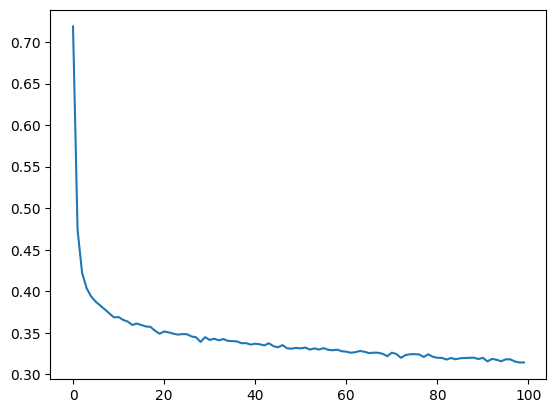

In [51]:
# Assuming we ran the training loop again...
# Plotting the loss with some smoothing to see the trend better
plt.plot(torch.tensor(loss_log).view(-1, 1000).mean(1))

Layer 2 (Tanh): mean 0.01, std 0.93
Layer 4 (Tanh): mean 0.03, std 0.96
Layer 6 (Tanh): mean 0.01, std 0.96
Layer 8 (Tanh): mean 0.00, std 0.96
Layer 10 (Tanh): mean 0.01, std 0.96
Layer 12 (Tanh): mean 0.01, std 0.96
Layer 14 (Tanh): mean 0.03, std 0.96


Text(0.5, 1.0, 'Activation distribution')

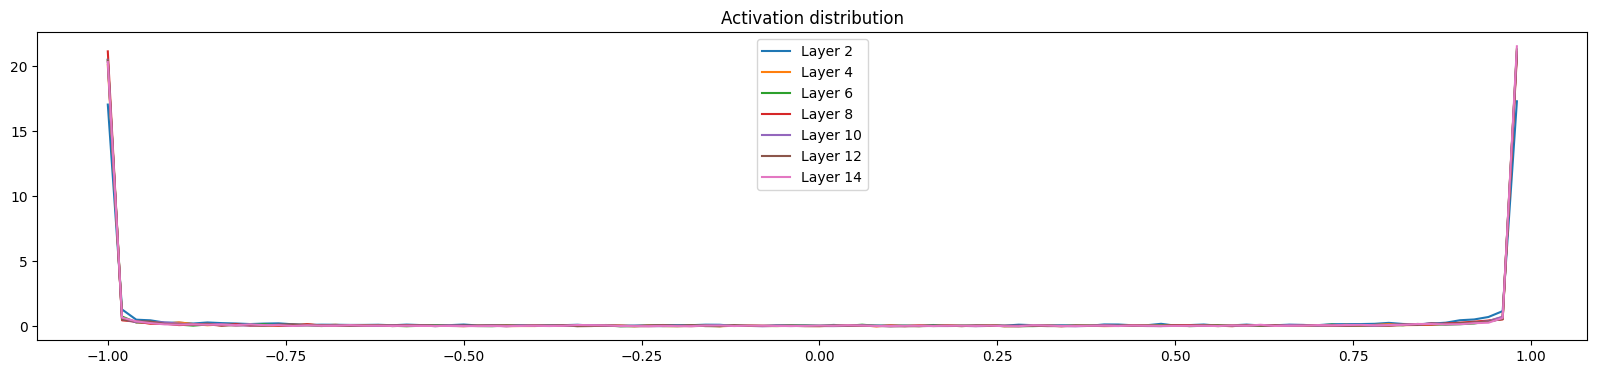

In [52]:
# Re-building a deeper model (7 hidden layers) for analysis
layers = [Embedding(charset_len, emb_d), Linear(emb_d * context_size, n_hidden), Tanh()]
for _ in range(6): # Adding more layers
    layers.append(Linear(n_hidden, n_hidden))
    layers.append(Tanh())
layers.append(Linear(n_hidden, charset_len))
model = layers

# Need to run a forward pass to populate 'layer.out'
with torch.no_grad():
    # Pick a random batch
    ix = torch.randint(0, len(Xtr), (64,), generator=g)
    Xb = Xtr[ix]
    x = Xb
    for layer in model:
        x = layer(x)

# Visualize mean and std of activations
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(model[:-1]): # skip output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std {t.std():.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i}')
plt.legend(legends)
plt.title('Activation distribution')

In [53]:
# Histogram of layer saturation (Karpathy https://youtu.be/P6sfmUTpUmc?feature=shared&t=5242)

Layer 2: 79.63% saturated
Layer 4: 88.75% saturated
Layer 6: 89.53% saturated
Layer 8: 89.59% saturated
Layer 10: 89.50% saturated
Layer 12: 89.03% saturated
Layer 14: 89.29% saturated


Text(0.5, 1.0, 'Tanh Saturation')

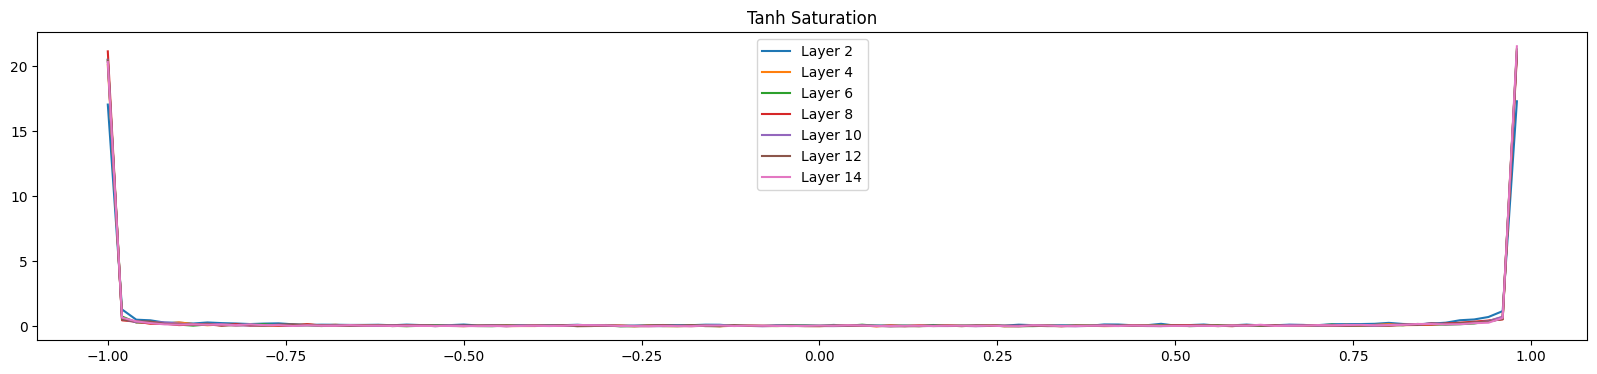

In [54]:
# Visualizing the "dead" or saturated neurons (values close to -1 or 1)
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(model[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad if layer.out.grad is not None else layer.out # Grab activations
        # If the value is > 0.9, it's saturated (gradient will be killed)
        print(f'Layer {i}: {((t.abs() > 0.9).float().mean() * 100):.2f}% saturated')
        
        # Karpathy style histogram
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i}')

plt.legend(legends)
plt.title('Tanh Saturation')

### Extra Exercises

* **Train the model using the dataset of city names encoded in Punycode. (Easy)**


* **Write a function that receives a list of city names. (Easy)**
    * If a city name starts with `xn--`, assume it is encoded in Punycode. The function should return the fraction of Punycode-encoded city names that can be successfully decoded.
    * **Hint:** The `punydecode` function allows decoding both normal strings and Punycode strings. It only fails if the Punycode is invalid. For normal strings, if the characters are valid (e.g., the string is all lowercase), it does not return an error.
    * **Example:** `my_puny_checker(['roma', 'xn--pars-xpa', 'atenas', 'xn--'])` should return `0.5`. This is because `punydecode` cannot decode `xn--`. The cities `roma` and `atenas` are not included in the statistics. We will call this metric the **"puny fraction"**.

* **Determine the "puny fraction" of the first 100 city names generated by the model from the previous point. (Easy)**

* **Train a model that uses both datasets, `puny` and `nopuny`. (Easy)**
    * Determine the "puny fraction" of the first 100 city names that begin with `xn--`.

In [55]:
# Exercise 1
import torch
import torch.nn.functional as F

# 1. Load Data
# We attempt to read the file. If not found, we use a fallback list for demonstration.
dataset_file = 'city_names_full.txt'
try:
    with open(dataset_file, 'r', encoding='utf-8') as f:
        raw_names = f.read().splitlines()
except FileNotFoundError:
    # Fallback data if file is missing in this environment
    raw_names = [
        "Heist-op-den-Berg", "Harchies", "Florennes", "Hévié", "Bingo",
        "Santa Rosa de Yacuma", "Huanuni", "Achacachi", "Viçosa do Ceará", 
        "São Vicente do Seridó", "Santa Luzia", "Salinópolis"
    ]

# 2. Split and Encode Data
# Logic: Pure ASCII -> No Punycode. Non-ASCII -> Encode to Punycode.
puny_dataset = []
nopuny_dataset = []

def is_pure_ascii(s):
    try:
        s.encode('ascii')
        return True
    except UnicodeEncodeError:
        return False

for name in raw_names:
    if is_pure_ascii(name):
        nopuny_dataset.append(name)
    else:
        # For non-ASCII, we must encode to Punycode.
        # Punycode/IDNA does not allow spaces, so we swap them for hyphens.
        try:
            encoded = name.replace(' ', '-').encode('idna').decode('ascii')
            puny_dataset.append(encoded)
        except:
            pass

print(f"Punycode dataset size: {len(puny_dataset)}")
print(f"Regular ASCII dataset size: {len(nopuny_dataset)}")

# 3. Build Vocabulary (Punycode Only)
# We add '*' as the start/stop token
chars = sorted(list(set(''.join(puny_dataset) + '*')))
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)

# 4. Build Tensors
def build_dataset(dataset, context_size, ctoi_map):
    X, Y = [], []
    stop_idx = ctoi_map['*']
    for word in dataset:
        context = [stop_idx] * context_size
        for char in word + '*':
            if char in ctoi_map:
                ix = ctoi_map[char]
                X.append(context)
                Y.append(ix)
                context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

context_size = 3
X_puny, Y_puny = build_dataset(puny_dataset, context_size, ctoi)

# 5. Define Model
emb_d = 10
n_hidden = 128
g = torch.Generator().manual_seed(42)

# Simple MLP definition
model_puny_layers = [
    torch.nn.Embedding(vocab_size, emb_d),
    torch.nn.Linear(emb_d * context_size, n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, vocab_size)
]

class MLP(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = torch.nn.ModuleList(layers)
    def forward(self, x):
        # Flatten embedding output
        x = self.layers[0](x)
        x = x.view(x.shape[0], -1) 
        for layer in self.layers[1:]:
            x = layer(x)
        return x

net_puny = MLP(model_puny_layers)
optimizer = torch.optim.SGD(net_puny.parameters(), lr=0.1)

# 6. Training Loop
print("Training Punycode Model...")
for i in range(30000):
    ix = torch.randint(0, len(X_puny), (64,), generator=g)
    Xb, Yb = X_puny[ix], Y_puny[ix]
    
    logits = net_puny(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i == 20000:
        for pg in optimizer.param_groups: pg['lr'] = 0.01

print(f"Final Loss: {loss.item():.4f}")

Punycode dataset size: 29089
Regular ASCII dataset size: 117949
Training Punycode Model...
Final Loss: 1.9614


In [56]:
#Exercice 2
def get_puny_fraction(names_list):
    """
    Calculates the fraction of strings starting with 'xn--' 
    that are valid Punycode.
    """
    candidates = 0
    valid = 0
    for name in names_list:
        # We only check strings that clearly attempt to be Punycode
        if name.startswith('xn--'):
            candidates += 1
            try:
                # Try decoding: ASCII -> IDNA -> Unicode
                name.encode('ascii').decode('idna')
                valid += 1
            except:
                continue
                
    return valid / candidates if candidates > 0 else 0.0

# Helper function for Visualization (decodes to UTF-8 for printing)
def print_decoded_samples(samples, title="Samples"):
    print(f"\n--- {title} ---")
    print(f"{'Raw Output':<30} | {'Decoded (UTF-8)'}")
    print("-" * 60)
    for s in samples:
        decoded = s
        if s.startswith('xn--'):
            try:
                decoded = s.encode('ascii').decode('idna')
            except:
                decoded = "❌ (Invalid Punycode)"
        print(f"{s:<30} | {decoded}")

In [57]:
# Exercice 3
def sample_model(model, ctoi_map, itoc_map, context_size, num_samples=100):
    generated = []
    stop_idx = ctoi_map['*']
    
    for _ in range(num_samples):
        out = []
        context = [stop_idx] * context_size
        while True:
            x = torch.tensor([context])
            with torch.no_grad():
                logits = model(x)
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
            
            if ix == stop_idx: break
            out.append(itoc_map[ix])
            context = context[1:] + [ix]
            if len(out) > 50: break # Safety break
        
        generated.append("".join(out))
    return generated

# Generate from Punycode-only model
samples_puny = sample_model(net_puny, ctoi, itoc, context_size, 100)
fraction_puny = get_puny_fraction(samples_puny)

print(f"\nPuny Fraction (Model 1): {fraction_puny:.2f}")

# VISUALIZATION: Print first 10 samples decoded
print_decoded_samples(samples_puny[:10], title="Model 1 (Punycode Only) Results")


Puny Fraction (Model 1): 0.49

--- Model 1 (Punycode Only) Results ---
Raw Output                     | Decoded (UTF-8)
------------------------------------------------------------
xn--ita                        | ̡
xn--lfb4fc                     | ❌ (Invalid Punycode)
xn--uuz-bsad-iscarlasmards-dy-poa | ❌ (Invalid Punycode)
xn--billeva43a                 | 㙉㙉㙂㘼㙾㙃
xn--mliamarachla-adir-teu-ardornhan-13a | ❌ (Invalid Punycode)
xn--vgbnoc-bueli-qrin-grdiva-gwa | ❌ (Invalid Punycode)
xn--gl-wqc                     | ❌ (Invalid Punycode)
xn--ters-bzb                   | ❌ (Invalid Punycode)
xn--badr-v3a                   | bŏadr
xn--ro-/-vua                   | ❌ (Invalid Punycode)


In [58]:
#Exercice 4
mixed_dataset = nopuny_dataset + puny_dataset

# 2. Mixed Vocabulary
# This vocab contains both regular letters (a-z) and Punycode artifacts (hyphens, numbers)
chars_mixed = sorted(list(set(''.join(mixed_dataset) + '*')))
ctoi_mixed = {c: i for i, c in enumerate(chars_mixed)}
itoc_mixed = {i: c for i, c in enumerate(chars_mixed)}
vocab_size_mixed = len(chars_mixed)

# 3. Build Mixed Tensors
X_mixed, Y_mixed = build_dataset(mixed_dataset, context_size, ctoi_mixed)

# 4. Define Mixed Model
model_mixed_layers = [
    torch.nn.Embedding(vocab_size_mixed, emb_d),
    torch.nn.Linear(emb_d * context_size, n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, vocab_size_mixed)
]
net_mixed = MLP(model_mixed_layers)
opt_mixed = torch.optim.SGD(net_mixed.parameters(), lr=0.1)

# 5. Train
print("\nTraining Mixed Model...")
for i in range(40000):
    ix = torch.randint(0, len(X_mixed), (64,), generator=g)
    Xb, Yb = X_mixed[ix], Y_mixed[ix]
    
    logits = net_mixed(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    opt_mixed.zero_grad()
    loss.backward()
    opt_mixed.step()
    
    if i == 30000:
        for pg in opt_mixed.param_groups: pg['lr'] = 0.01

# 6. Evaluate
samples_mixed = sample_model(net_mixed, ctoi_mixed, itoc_mixed, context_size, 200)
fraction_mixed = get_puny_fraction(samples_mixed)

print(f"Puny Fraction (Mixed Model): {fraction_mixed:.2f}")

# VISUALIZATION:
# We filter to show some 'xn--' samples to verify decoding
puny_samples = [s for s in samples_mixed if s.startswith('xn--')]
ascii_samples = [s for s in samples_mixed if not s.startswith('xn--')]

print_decoded_samples(puny_samples[:5], title="Mixed Model (Punycode Generated)")
print_decoded_samples(ascii_samples[:5], title="Mixed Model (Regular Generated)")


Training Mixed Model...
Puny Fraction (Mixed Model): 0.45

--- Mixed Model (Punycode Generated) ---
Raw Output                     | Decoded (UTF-8)
------------------------------------------------------------
xn--san-2bb                    | ǂsan
xn--bellah-65a                 | bellğah
xn--de-5eb                     | dɑe
xn--bhac                       | ❌ (Invalid Punycode)
xn--ber Afmokret               | ❌ (Invalid Punycode)

--- Mixed Model (Regular Generated) ---
Raw Output                     | Decoded (UTF-8)
------------------------------------------------------------
Sunsheirb7a                    | Sunsheirb7a
Hente-rwak                     | Hente-rwak
Dast Barosra                   | Dast Barosra
Lnica                          | Lnica
Boke Malburg                   | Boke Malburg
